<a href="https://colab.research.google.com/github/qlin1996/NYC_Property_Sales/blob/master/NYC_Property_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Have some cash on hand and thinking about investing in NYC real estate? Or maybe you have a property and are debating about getting rid of it? Whether you are buying or selling property, be sure to read this report before making a decision.

In this report, I analyze New York City's property sales from 2016 to 2019 for trends in property location, property demand and sale prices. The specific questions I answer are:

*   How has property demand and sale price fluctuated over the years?
*   What *boroughs* sold the most properties and at what price?
*   What *neigbhorhoods* sold the most properties and at what price?
*   What were hottest buildings in each borough and how much did they sell for?
*   What were the sizes of the properties sold in each borough?
*   Were there more newer or older properties sold?
*   What affects sale price? Is there a correlation between sale price and land sq ft, gross sq ft, or the year in which the property was built?

Please note the data I used in this report is from the New York City Department of Finance.

# Housekeeping

## Importing Libraries, Reading Data, and Setting Style

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
full_data = pd.read_csv('/content/drive/My Drive/NYC_Citywide_Annualized_Calendar_Sales_Update.csv')
sns.set(context= 'notebook', style='ticks', palette='muted', font='sans-serifs', font_scale=1.2, color_codes=True, rc={'lines.linewidth': 1.75, 'figure.figsize': (9, 6)})

## Data Dictionary

*   **BOROUGH**
*   **NEIGHBORHOOD**
*   **BUILDING CLASS**: Identifies properties broad usage (e.g. One Family Home)
*   **ADDRESS**: Note that co-op sales include the apartment in the address field
*   **LAND SQUARE FEET**: The land area of the property listed in square feet
*   **GROSS SQUARE FEET**: The total area of all the floors of a building as measured from the exterior surfaces of the outside walls of the building, including the land area and space within any building or structure on the property
*   **YEAR BUILT**
*   **SALE PRICE**
*   **SALE MONTH**
*   **SALE YEAR**
*   **SALE DATE**

## Preview of Raw Data

There are 29 columns and 345,059 rows in the full data set.

In [0]:
# Columns, null values, counts, and dtypes
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345059 entries, 0 to 345058
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BOROUGH                          345059 non-null  int64  
 1   NEIGHBORHOOD                     345059 non-null  object 
 2   BUILDING CLASS CATEGORY          345059 non-null  object 
 3   TAX CLASS AS OF FINAL ROLL       341199 non-null  object 
 4   BLOCK                            345059 non-null  int64  
 5   LOT                              345059 non-null  int64  
 6   EASE-MENT                        0 non-null       float64
 7   BUILDING CLASS AS OF FINAL ROLL  341199 non-null  object 
 8   ADDRESS                          345059 non-null  object 
 9   APARTMENT NUMBER                 74790 non-null   object 
 10  ZIP CODE                         345044 non-null  float64
 11  RESIDENTIAL UNITS                329081 non-null  float64
 12  CO

In [0]:
# Sample of raw data
full_data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,EASE-MENT,BUILDING CLASS AS OF FINAL ROLL,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,1,FINANCIAL,14 RENTALS - 4-10 UNIT,2A,7,38,NaN,S9,60 PEARL STREET,NaN,10004.0,3.0,2.0,5.0,"1,491","7,485",1900.0,2,S9,4027000,01/01/2016,40.703553,-74.011152,101.0,1.0,9.0,1000014.0,1.000070e+09,Battery Park City-Lower Manhattan
1,1,HARLEM-EAST,01 ONE FAMILY DWELLINGS,1,1643,122,NaN,A4,155 EAST 115 STREET,NaN,10029.0,1.0,0.0,1.0,"1,345","2,800",1900.0,1,A4,0,01/01/2016,40.797761,-73.941667,111.0,8.0,182.0,1052276.0,1.016430e+09,East Harlem North
2,1,HARLEM-EAST,07 RENTALS - WALKUP APARTMENTS,2,1643,123,NaN,C5,157 EAST 115 STREET,NaN,10029.0,12.0,1.0,13.0,"1,345","3,535",1900.0,2,C5,0,01/01/2016,40.797744,-73.941627,111.0,8.0,182.0,1052277.0,1.016430e+09,East Harlem North
3,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1320,4247,NaN,R4,211 EAST 46TH STREET,33J,10017.0,1.0,0.0,1.0,- 0,- 0,1979.0,2,R4,0,01/01/2016,40.753118,-73.972085,106.0,4.0,90.0,1037599.0,1.013208e+09,Turtle Bay-East Midtown
4,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1365,1526,NaN,R4,400 EAST 54TH STREET,30H,10022.0,1.0,0.0,1.0,- 0,- 0,1972.0,2,R4,0,01/01/2016,40.756237,-73.963995,106.0,4.0,8603.0,1076281.0,1.013658e+09,Turtle Bay-East Midtown


## Cleaning Data

I filter the data by dropping duplicates and columns I choose not to investigate. I rename the values in the "Borough" so it's easier to read and also convert the columns to their appropriate data types.

In [0]:
# Create a copy
predrop = full_data.copy()

# Drop duplicates
predrop.drop_duplicates(keep='first', inplace=True)

# Drop columns we choose not to investigate
predrop.drop(columns=['ZIP CODE','TAX CLASS AT TIME OF SALE','BLOCK', 'TAX CLASS AS OF FINAL ROLL','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LOT', 'EASE-MENT', 'BUILDING CLASS AS OF FINAL ROLL', 'APARTMENT NUMBER', 'TOTAL UNITS', 'BUILDING CLASS AT TIME OF SALE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA'], inplace=True)

# Rename columns
predrop.rename(columns={'BUILDING CLASS CATEGORY': 'BUILDING CLASS'}, inplace=True)

# Convert the values (1-5) in the "BOROUGH" column to their actual names
predrop['BOROUGH'].replace({1:'MANHATTAN', 2:'BRONX', 3: 'BROOKLYN', 4: 'QUEENS', 5:'STATEN ISLAND'}, inplace=True)

# Convert 'SALE DATE' to date type and add columns "SALE MONTH" and "SALE DATE"
predrop['SALE DATE'] = pd.to_datetime(predrop['SALE DATE'])
predrop['SALE MONTH'] = predrop['SALE DATE'].dt.month
predrop['SALE YEAR'] = predrop['SALE DATE'].dt.year
predrop.sort_values(by=['SALE YEAR', 'SALE MONTH'], ascending=True, inplace=True)
predrop.drop(columns='SALE DATE', inplace=True)

# Convert all the date columns to string type and write out the values (1-12) in the "SALE MONTH" column
predrop['SALE MONTH'] = predrop['SALE MONTH'].map(lambda x: str(x))
predrop['SALE MONTH'].replace({'1':'Jan', '2':'Feb', '3': 'Mar', '4': 'Apr', '5':'May', '6':'Jun', '7':'Jul', '8': 'Aug', '9': 'Sept', '10':'Oct',  '11': 'Nov', '12':'Dec'}, inplace=True)
predrop['SALE YEAR'] = predrop['SALE YEAR'].map(lambda x: str(x))
predrop['SALE DATE'] = predrop['SALE MONTH'] + ' ' + predrop['SALE YEAR']

I also clean the "BUILDING CLASS" column and remove duplicates that are not dropped during the first round. These duplicates have weird spacings in it that cause the program to think they are unique values. 

In [0]:
# How the 'BUILDING CLASS' column looks pre-cleaned. The extra spacing between the number and the name cause the system to not read it as duplicates.
print('Number of "unique values:')
print(predrop['BUILDING CLASS'].nunique())
print('List of unique values:')
print(predrop['BUILDING CLASS'].unique())

Number of "unique values:
91
List of unique values:
['14  RENTALS - 4-10 UNIT' '01  ONE FAMILY DWELLINGS'
 '07  RENTALS - WALKUP APARTMENTS' '13  CONDOS - ELEVATOR APARTMENTS'
 '26  OTHER HOTELS' '47  CONDO NON-BUSINESS STORAGE' '22  STORE BUILDINGS'
 '21  OFFICE BUILDINGS' '31  COMMERCIAL VACANT LAND'
 '35  INDOOR PUBLIC AND CULTURAL FACILITIES' '05  TAX CLASS 1 VACANT LAND'
 '08  RENTALS - ELEVATOR APARTMENTS' '29  COMMERCIAL GARAGES'
 '02  TWO FAMILY DWELLINGS' '10  COOPS - ELEVATOR APARTMENTS'
 '03  THREE FAMILY DWELLINGS' '04  TAX CLASS 1 CONDOS' '45  CONDO HOTELS'
 '15  CONDOS - 2-10 UNIT RESIDENTIAL' '09  COOPS - WALKUP APARTMENTS'
 '44  CONDO PARKING' '34  THEATRES' '12  CONDOS - WALKUP APARTMENTS'
 '17  CONDO COOPS' '30  WAREHOUSES' '37  RELIGIOUS FACILITIES'
 '43  CONDO OFFICE BUILDINGS' '27  FACTORIES' '06  TAX CLASS 1 - OTHER'
 '16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT' '41  TAX CLASS 4 - OTHER'
 '32  HOSPITAL AND HEALTH FACILITIES' '25  LUXURY HOTELS'
 '49  CONDO WAREHO

In [0]:
# After filtering out first two number and the extra space, there were 47 unique building types 
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].str[3:]
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].apply(lambda x : x[1:] if x.startswith(" ") else x)
print('True number of unique values:')
print(predrop['BUILDING CLASS'].nunique())
print('List of unique values:')
print(predrop['BUILDING CLASS'].unique())

True number of unique values:
47
List of unique values:
['RENTALS - 4-10 UNIT' 'ONE FAMILY DWELLINGS'
 'RENTALS - WALKUP APARTMENTS' 'CONDOS - ELEVATOR APARTMENTS'
 'OTHER HOTELS' 'CONDO NON-BUSINESS STORAGE' 'STORE BUILDINGS'
 'OFFICE BUILDINGS' 'COMMERCIAL VACANT LAND'
 'INDOOR PUBLIC AND CULTURAL FACILITIES' 'TAX CLASS 1 VACANT LAND'
 'RENTALS - ELEVATOR APARTMENTS' 'COMMERCIAL GARAGES'
 'TWO FAMILY DWELLINGS' 'COOPS - ELEVATOR APARTMENTS'
 'THREE FAMILY DWELLINGS' 'TAX CLASS 1 CONDOS' 'CONDO HOTELS'
 'CONDOS - 2-10 UNIT RESIDENTIAL' 'COOPS - WALKUP APARTMENTS'
 'CONDO PARKING' 'THEATRES' 'CONDOS - WALKUP APARTMENTS' 'CONDO COOPS'
 'WAREHOUSES' 'RELIGIOUS FACILITIES' 'CONDO OFFICE BUILDINGS' 'FACTORIES'
 'TAX CLASS 1 - OTHER' 'CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT'
 'TAX CLASS 4 - OTHER' 'HOSPITAL AND HEALTH FACILITIES' 'LUXURY HOTELS'
 'CONDO WAREHOUSES/FACTORY/INDUS' 'CONDO STORE BUILDINGS' 'LOFT BUILDINGS'
 'EDUCATIONAL FACILITIES' 'CONDO TERRACES/GARDENS/CABANAS'
 'ASYLUMS AND

For the "SALE PRICE" column, I filter out sale prices <= $0 as I consider those as a mere transfer of ownership rather than a sale. 

In [0]:
# Make a copy to drop values
nyc_property_sales = predrop.copy()

# Filter out property sale price of < $0
def price_filter(price):
  if (price<=0.0):
    return np.NaN
  else: 
    return price
nyc_property_sales['SALE PRICE'] = nyc_property_sales['SALE PRICE'].apply(price_filter)

Moving on to the "LAND SQUARE FEET" and "GROSS SQUARE FEET" columns, I drop negative values and convert the dtypes to int.

In [0]:
# Count number of -0 values for later use
print('Number of -0 vlaues in "LAND SQAURE FEET":')
print(len(nyc_property_sales[nyc_property_sales['LAND SQUARE FEET']=='- 0']))
print('Number of -0 vlaues in "GROSSSQAURE FEET":')
print(len(nyc_property_sales[nyc_property_sales['GROSS SQUARE FEET']=='- 0']))

# Convert 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' to numbers. if value is null, fill with -1 so we can drop it later.
nyc_property_sales['LAND SQUARE FEET'] = nyc_property_sales['LAND SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)
nyc_property_sales['GROSS SQUARE FEET'] = nyc_property_sales['GROSS SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)

# Delete rows with null values and rows with -1 in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET'
nyc_property_sales.dropna(axis=0, how='any', inplace=True)
nyc_property_sales.drop = nyc_property_sales[(nyc_property_sales['LAND SQUARE FEET']!=-1) | (nyc_property_sales['GROSS SQUARE FEET']!=-1)]

Number of -0 vlaues in "LAND SQAURE FEET":
74668
Number of -0 vlaues in "GROSSSQAURE FEET":
85507


For the "YEAR BUILT" column, I notice the minimum value is 0, which isn't realistic so I drop the rows with this value.

In [0]:
# Description of each numeric column
# Note some properties have a 0 land sq ft so dividing price by 0 will get you inf
nyc_property_sales.describe()

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,2.356160e+05,2.356160e+05,235616.000000,2.356160e+05
mean,3.563351e+03,2.590757e+03,1831.344654,1.639239e+06
std,6.618804e+04,2.444341e+04,468.579069,1.450774e+07
min,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,0.000000e+00,0.000000e+00,1920.000000,3.820000e+05
50%,1.600000e+03,1.012000e+03,1940.000000,6.400000e+05
75%,2.660000e+03,1.950000e+03,1966.000000,1.080000e+06
max,1.985040e+07,3.750565e+06,2020.000000,2.397502e+09


In [0]:
# Drop rows with 0 'YEAR BUILT' and convert to int type
nyc_property_sales = nyc_property_sales[nyc_property_sales['YEAR BUILT']>0.0]
nyc_property_sales['YEAR BUILT'] = nyc_property_sales['YEAR BUILT'].map(lambda x: int(x))

I summarize what I dropped from each column in the chart below. Note that >20% of values in the Land Square Feet, Gross Square Feet, and Sale Price columns were dropped. Please keep in mind that these dropped values could have skewed our results in another direction.

In [0]:
# Percentage of nulls/0s/invalid values dropped from each column
invalids_cells = pd.DataFrame([],index = nyc_property_sales.columns, columns=['Invalid Counts Dropped (%)'])
invalids_cells.loc['BOROUGH'] = (len(nyc_property_sales)-nyc_property_sales['BOROUGH'].count()) / len(predrop) * 100
invalids_cells.loc['NEIGHBORHOOD'] = (len(nyc_property_sales)-nyc_property_sales['NEIGHBORHOOD'].count()) /len(predrop) * 100
invalids_cells.loc['BUILDING CLASS'] = (len(nyc_property_sales)-nyc_property_sales['BUILDING CLASS'].count()) / len(predrop) * 100
invalids_cells.loc['ADDRESS'] = (len(nyc_property_sales)-nyc_property_sales['ADDRESS'].count()) / len(predrop) * 100
invalids_cells.loc['LAND SQUARE FEET'] = (len(nyc_property_sales)-nyc_property_sales['LAND SQUARE FEET'].count() + 74669) / len(predrop) * 100
invalids_cells.loc['GROSS SQUARE FEET'] = (len(nyc_property_sales)-nyc_property_sales['GROSS SQUARE FEET'].count() + 85507) / len(predrop) * 100
invalids_cells.loc['YEAR BUILT'] = ((len(nyc_property_sales)-nyc_property_sales['YEAR BUILT'].count()) + len(predrop[predrop['YEAR BUILT']==0.0])) / len(predrop) * 100
invalids_cells.loc['SALE PRICE'] = ((len(nyc_property_sales)-nyc_property_sales['SALE PRICE'].count()) + len(predrop[predrop['SALE PRICE']<=0.0])) / len(predrop) * 100
invalids_cells.loc['SALE MONTH'] = (len(nyc_property_sales)-nyc_property_sales['SALE MONTH'].count()) / len(predrop) * 100
invalids_cells.loc['SALE YEAR'] = (len(nyc_property_sales)-nyc_property_sales['SALE YEAR'].count()) / len(predrop) * 100
invalids_cells.loc['SALE DATE'] = (len(nyc_property_sales)-nyc_property_sales['SALE DATE'].count()) / len(predrop) * 100
invalids_cells

,Invalid Counts Dropped (%)
BOROUGH,0
NEIGHBORHOOD,0
BUILDING CLASS,0
ADDRESS,0
LAND SQUARE FEET,21.8176
GROSS SQUARE FEET,24.9844
YEAR BUILT,6.87058
SALE PRICE,30.103
SALE MONTH,0
SALE YEAR,0


## Preview of Cleaned Sample

In [0]:
# Columns, null values, counts, and dtypes
nyc_property_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221206 entries, 0 to 344398
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   BOROUGH            221206 non-null  object 
 1   NEIGHBORHOOD       221206 non-null  object 
 2   BUILDING CLASS     221206 non-null  object 
 3   ADDRESS            221206 non-null  object 
 4   LAND SQUARE FEET   221206 non-null  int64  
 5   GROSS SQUARE FEET  221206 non-null  int64  
 6   YEAR BUILT         221206 non-null  int64  
 7   SALE PRICE         221206 non-null  float64
 8   SALE MONTH         221206 non-null  object 
 9   SALE YEAR          221206 non-null  object 
 10  SALE DATE          221206 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 20.3+ MB


In [0]:
# Sample data post-cleaned
nyc_property_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
0,MANHATTAN,FINANCIAL,RENTALS - 4-10 UNIT,60 PEARL STREET,1491,7485,1900,4027000.0,Jan,2016,Jan 2016
14,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,12500,22680,1932,384000.0,Jan,2016,Jan 2016
16,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,12500,22680,1932,2288000.0,Jan,2016,Jan 2016
19,BRONX,SCHUYLERVILLE/PELHAM BAY,OFFICE BUILDINGS,3049 BUHRE AVENUE,7550,8550,1925,336000.0,Jan,2016,Jan 2016
24,BRONX,SCHUYLERVILLE/PELHAM BAY,INDOOR PUBLIC AND CULTURAL FACILITIES,3060 WESTCHESTER AVENUE,4568,4568,1937,480000.0,Jan,2016,Jan 2016


# Data Analysis and Visualization

## How has property demand and sale price fluctuated over the years?

I start my analysis by examining the fluctuation of property demand of NYC as a whole.

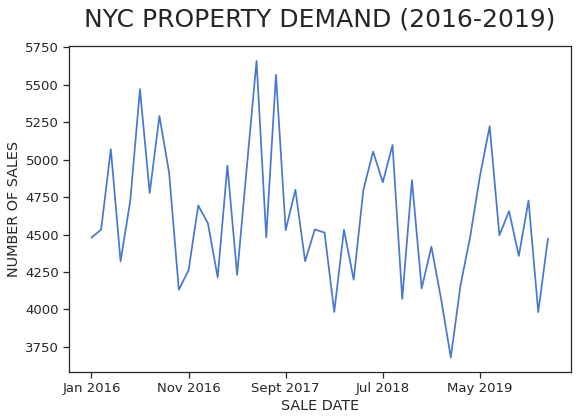

In [0]:
# Time and number of property sales
date_df = nyc_property_sales.groupby('SALE DATE', sort=False)['SALE PRICE'].count()

date_df.plot.line()
plt.title('NYC PROPERTY DEMAND (2016-2019)', fontsize=25, pad=20)
plt.ylabel('NUMBER OF SALES')
plt.show()

In [0]:
# Min and max number of sales by month, year
print(f'Min number of sales: {date_df.sort_values().iloc[0]} properties in {date_df.sort_values().index[0]}')
print(f'Max number of sales: {date_df.sort_values(ascending=False).iloc[0]} properties in {date_df.sort_values(ascending=False).index[0]}')

Min number of sales: 3679 properties in Feb 2019
Max number of sales: 5659 properties in Jun 2017


The numbers of monthly property sales between 2016-2019 vary greatly. Sales were at their lowest in June 2017 and their highest in February 2019. Also notice how the peaks and drops are pretty consistently spaced out. This got me wondering if there was a sales trend by months.

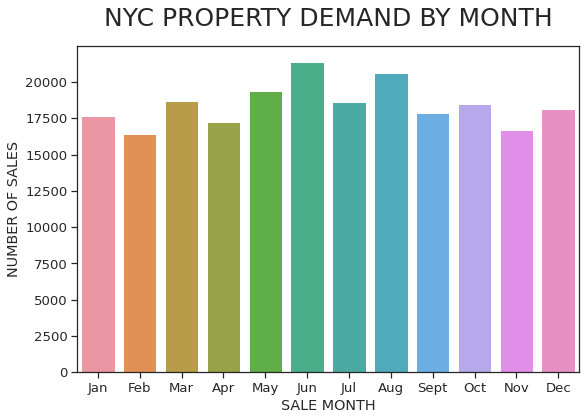

In [0]:
# Month and number of property sales
month_df = nyc_property_sales.groupby('SALE MONTH', sort=False)['SALE PRICE'].count()
month_df = month_df.reset_index().rename(columns={'SALE PRICE':'NUMBER OF SALES'})

sns.barplot(x='SALE MONTH', y='NUMBER OF SALES', data=month_df)
plt.title('NYC PROPERTY DEMAND BY MONTH', fontsize=25, pad=20)
plt.show()

As I suspect, most properties were sold during the warmer months.

So what about the average sale price of properties?

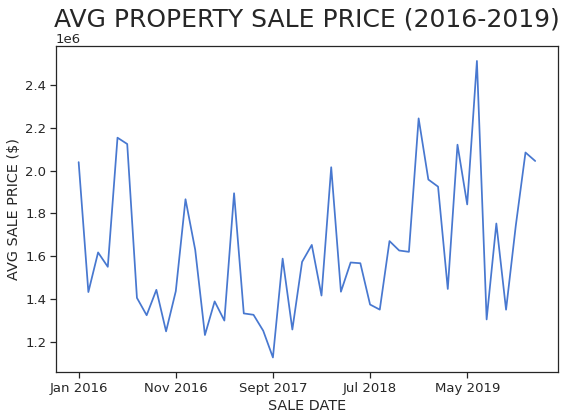

In [0]:
# Time and sale price 
date_df = nyc_property_sales.groupby('SALE DATE', sort=False)['SALE PRICE'].mean()

date_df.plot.line()
plt.title('AVG PROPERTY SALE PRICE (2016-2019)', fontsize=25, pad=20)
plt.ylabel('AVG SALE PRICE ($)')
plt.show()

I see that the average property sales prices also fluctuate greatly and that there is a small upward trend of price increase with time.

## What boroughs sold the most properties and at what price?

I continue my analysis by breaking down the number of sales by borough. My goal was to figure out which borough had the most property sales and at what average price.

In [0]:
# Breakdown of sales count and price by borough
nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
BRONX,20049.0,8.907681e+05,3.341779e+06,1.0,255000.0,449490.0,635000.0,1.334000e+08
BROOKLYN,55848.0,1.344040e+06,5.911930e+06,1.0,464412.0,765000.0,1265000.0,8.696129e+08
MANHATTAN,51432.0,3.794513e+06,2.934822e+07,1.0,617000.0,1087186.0,2350000.0,2.397502e+09
QUEENS,70103.0,8.467754e+05,4.740818e+06,1.0,309000.0,525000.0,810000.0,4.750000e+08
STATEN ISLAND,23774.0,5.377019e+05,7.850955e+05,1.0,350000.0,485000.0,632000.0,5.200000e+07


In [0]:
# Number of sales by borough
sales_by_borough_count = nyc_property_sales.groupby('BOROUGH')['SALE DATE'].count()
sales_by_borough = sales_by_borough_count.reset_index().rename(columns={'SALE DATE':'NUMBER OF SALES'})
sales_by_borough

,BOROUGH,NUMBER OF SALES
0,BRONX,20049
1,BROOKLYN,55848
2,MANHATTAN,51432
3,QUEENS,70103
4,STATEN ISLAND,23774


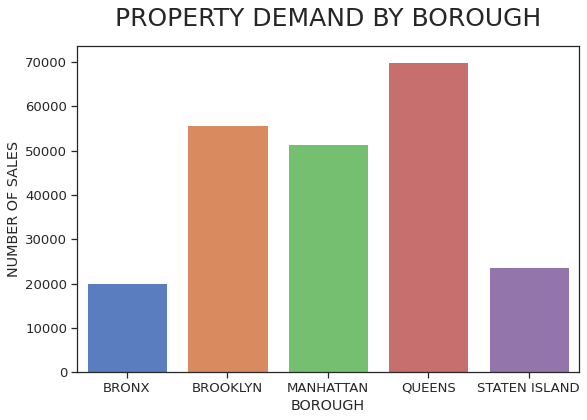

In [0]:
sns.barplot(x='BOROUGH', y= 'NUMBER OF SALES', data=sales_by_borough)
plt.title('PROPERTY DEMAND BY BOROUGH', fontsize=25, pad=20)
plt.show()

I find that the borough with the most property sale was Queens with 101,420 sales, followed by Brookylyn with 87,155 sales. Manhattan came in third with 63,753 sales and Staten Island fourth with 32,858 sales. Bronx ranked last with only 27,653 property sales.

In [0]:
# Avg sale price by borough
mean_price_by_borough = nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].mean()
mean_price_by_borough = mean_price_by_borough.reset_index()
mean_price_by_borough

,BOROUGH,SALE PRICE
0,BRONX,8.907681e+05
1,BROOKLYN,1.344040e+06
2,MANHATTAN,3.794513e+06
3,QUEENS,8.467754e+05
4,STATEN ISLAND,5.377019e+05


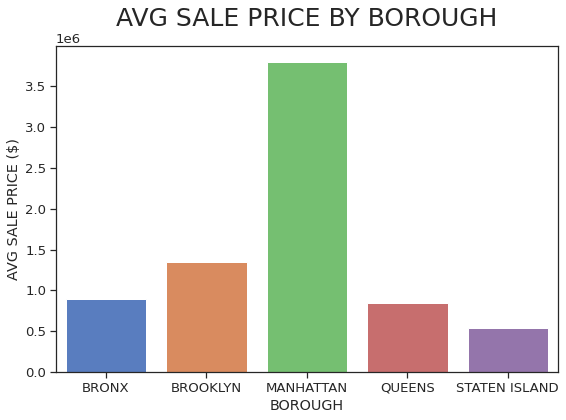

In [0]:
sns.barplot(x='BOROUGH', y='SALE PRICE', data=mean_price_by_borough)
plt.title('AVG SALE PRICE BY BOROUGH', fontsize=25, pad=20)
plt.ylabel('AVG SALE PRICE ($)')
plt.show()

Although Queens saw the most demand, properties were most expensive in Manhattan. The average price of which properties sold for in Manhattan was \$3.8m while in Queens, the average price was \$850k. Staten Island was the cheapest with an average price of \$538k.

I understand that Manhattan's high average sale price could be a result of its extreme outliers so I turn to look at the median to find out if Manhattan is still to hold the crown for being the most expensive borough.

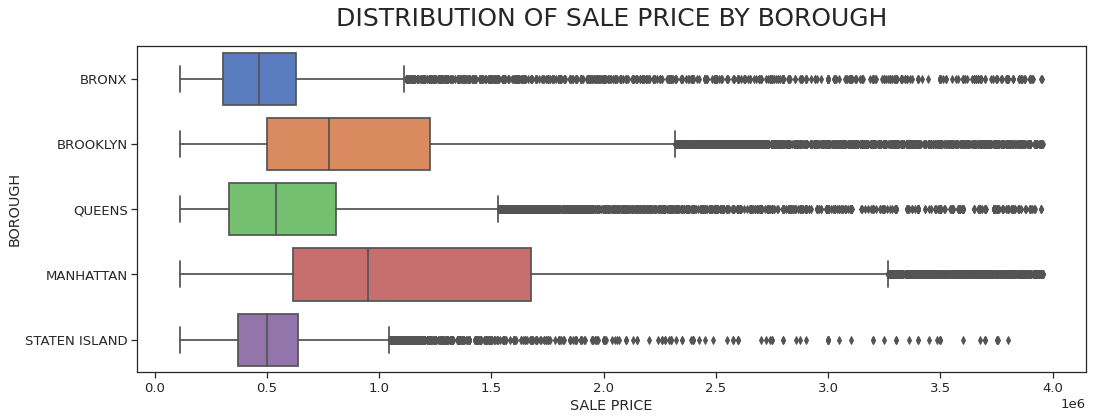

In [0]:
# Distribution of price by borough
sqft_cleaned = nyc_property_sales[nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.05), nyc_property_sales['SALE PRICE'].quantile(.95))]
plt.figure(figsize=(17,6))
sns.boxplot(x='SALE PRICE', y='BOROUGH', data=sqft_cleaned)
plt.title('DISTRIBUTION OF SALE PRICE BY BOROUGH', fontsize=25, pad=20)
plt.show()

Indeed, the crown still belongs to Manhattan. The properties in Manhattan had a higher median sale price than the other boroughs. 

## What neigborhoods sold the most properties and at what price?

After determining the breakdown of price by borough, I want to know how the numbers look when grouped by neigborhoods. I want to determine the number of sales and the average price across the most and least in-demand neigborhoods.

In [0]:
# Breakdown of sales count by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count().reset_index().rename(columns={'SALE DATE':'COUNT'}).sort_values(by='COUNT', ascending=False)

,NEIGHBORHOOD,COUNT
90,FLUSHING-NORTH,6687
233,UPPER EAST SIDE (59-79),5317
234,UPPER EAST SIDE (79-96),4779
154,MIDTOWN EAST,3647
236,UPPER WEST SIDE (59-79),3519
...,...,...
193,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3
183,PELHAM BAY,1


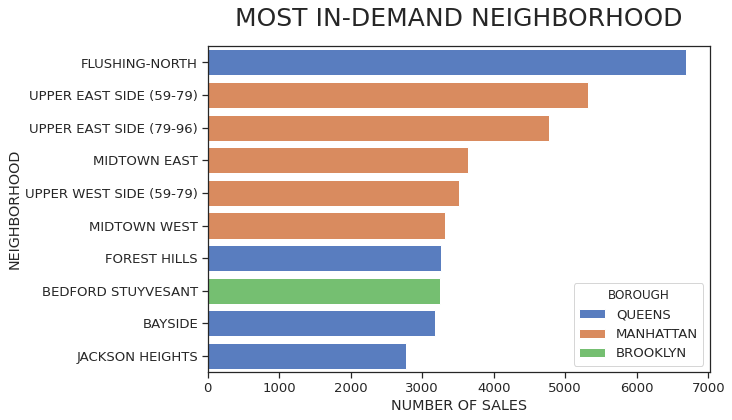

In [0]:
# Top 10 number of sales by neigborhood and color coded by borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=False, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'NUMBER OF SALES'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='NUMBER OF SALES', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.title('MOST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

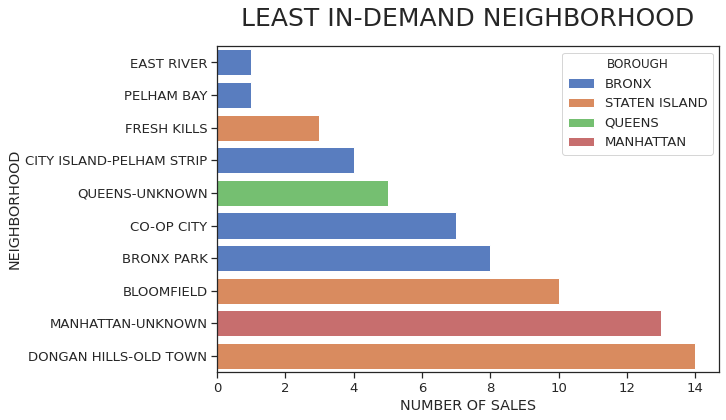

In [0]:
# Bottom 10 number of sales by borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=True, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'NUMBER OF SALES'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='NUMBER OF SALES', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.title('LEAST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

The numbers of properties sold by neighborhood is pretty consistent with our previous analysis on the number of properties sold by borough. The top most in-demand neighborhoods were in Queens and Manhattan (ranked first and third in properties sold by borough) and the top least in-demand neigborhoods were in Bronx and Staten Island (ranked fifth and fourth in properties sold by borough).

In [0]:
# Breakdown of sale price by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].count().reset_index().sort_values(by='SALE PRICE', ascending=False)

,NEIGHBORHOOD,SALE PRICE
90,FLUSHING-NORTH,6687
233,UPPER EAST SIDE (59-79),5317
234,UPPER EAST SIDE (79-96),4779
154,MIDTOWN EAST,3647
236,UPPER WEST SIDE (59-79),3519
...,...,...
193,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3
183,PELHAM BAY,1


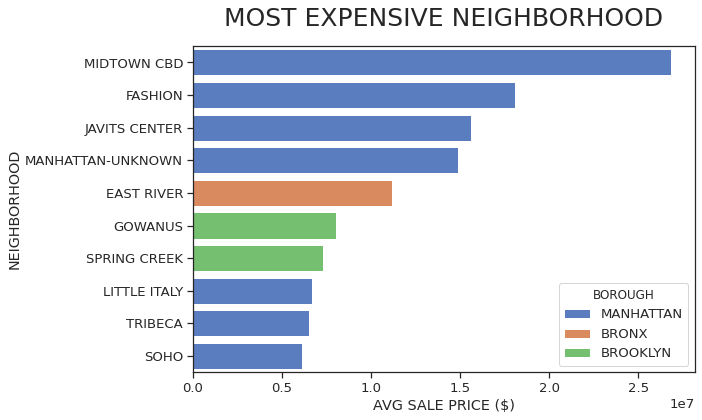

In [0]:
# Sale price of top 10 neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=False, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('MOST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

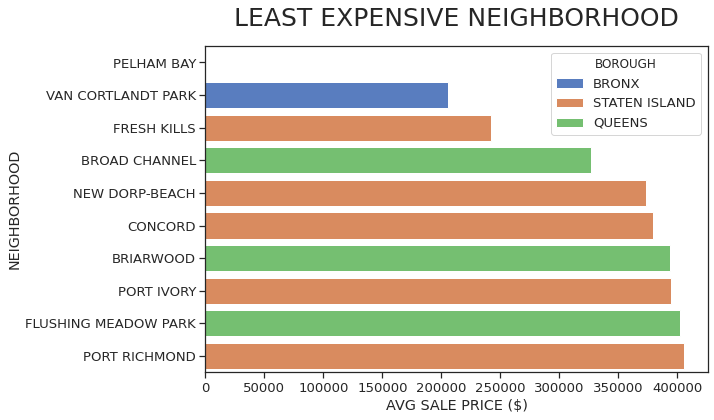

In [0]:
# Sale price of bottom 10 neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=True, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('LEAST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

The average price of properties sold by neighborhood is also pretty consistent with the average price of properties sold by borough. 7 of the top 10 most expensive neigborhoods were in Manhattan, which matches with what had previously found. 7 of the top 10 least expensive neighorhoods were in Staten Island and Bronx which also matches with what we found earlier.

## What were hottest buildings in each borough and how much did they sell for?

Now that I know the demand and price of properties, I can't help but wonder the type of buildings that these properties were. In this section, I examine for the most in-demand and most expensive building classes sold.

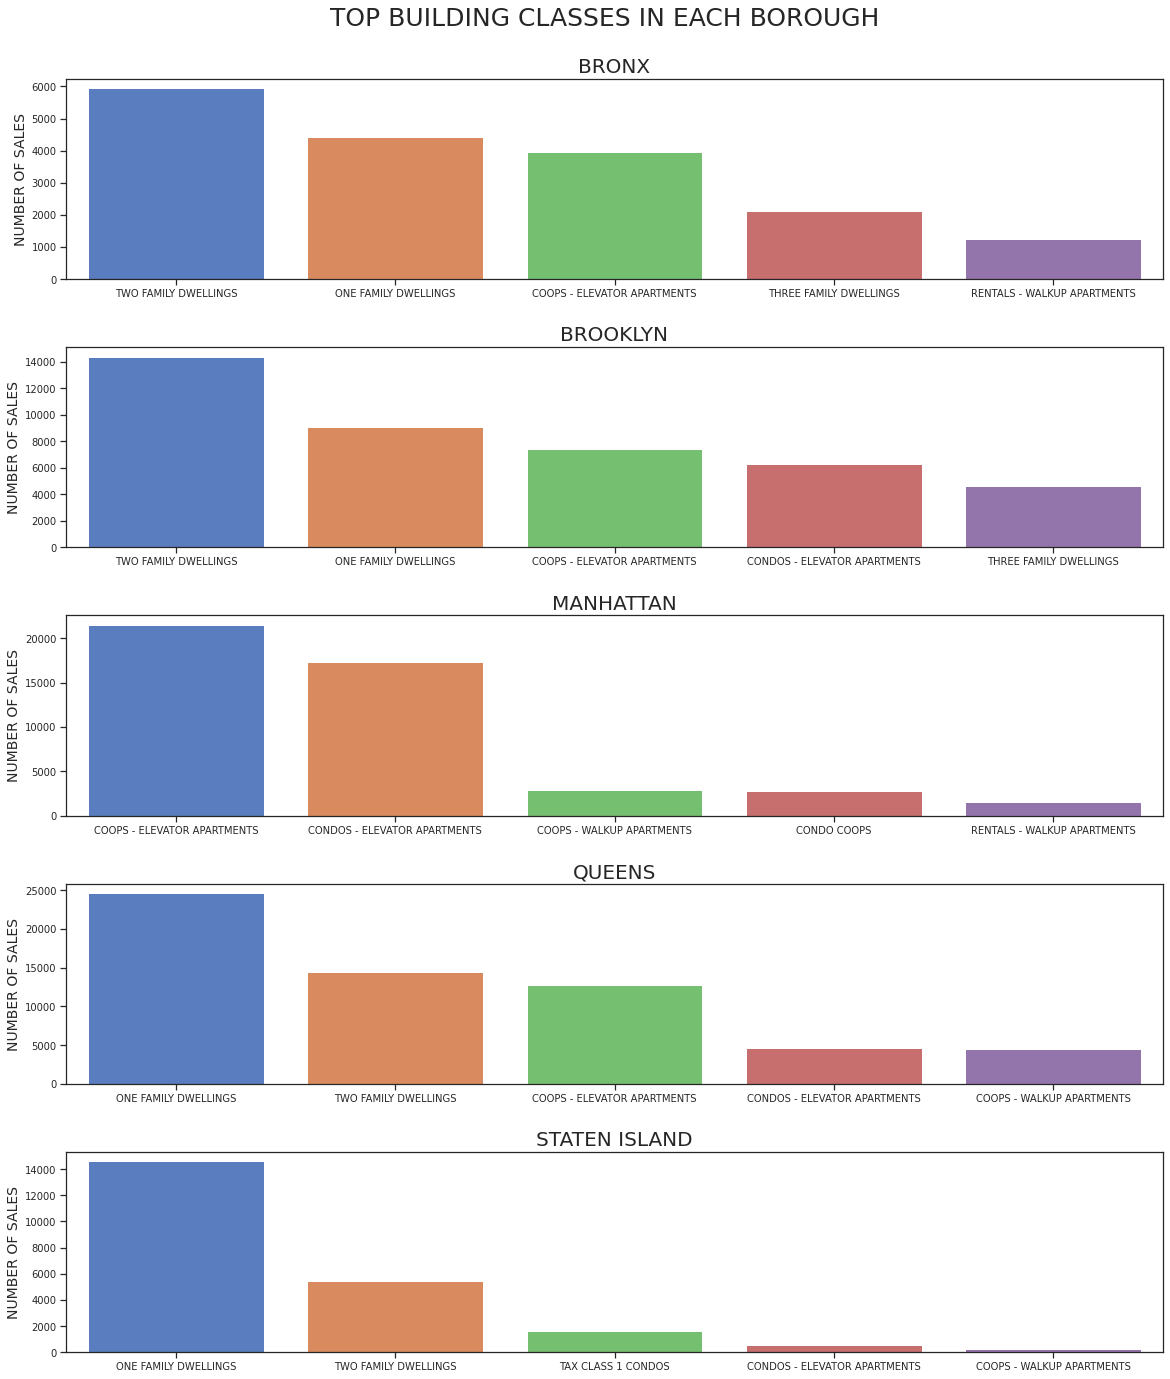

In [0]:
# Top 5 building classes sold in each borough 
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('TOP BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  b = sns.barplot(y='BUILDING CLASS', x='index', data=building_by_borough.get_group(group)['BUILDING CLASS'].value_counts().head(5).reset_index(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('NUMBER OF SALES',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()

The most in-demand building classes in the Bronx, Brooklyn, Queens and Staten Island were one/two family dwellings. This makes me think that these 4 boroughs are more spacious and are attractive to families. Meanwhile in Manhattan, Co-ops and Condo are more popular which makes sense as space is more limited in the city.

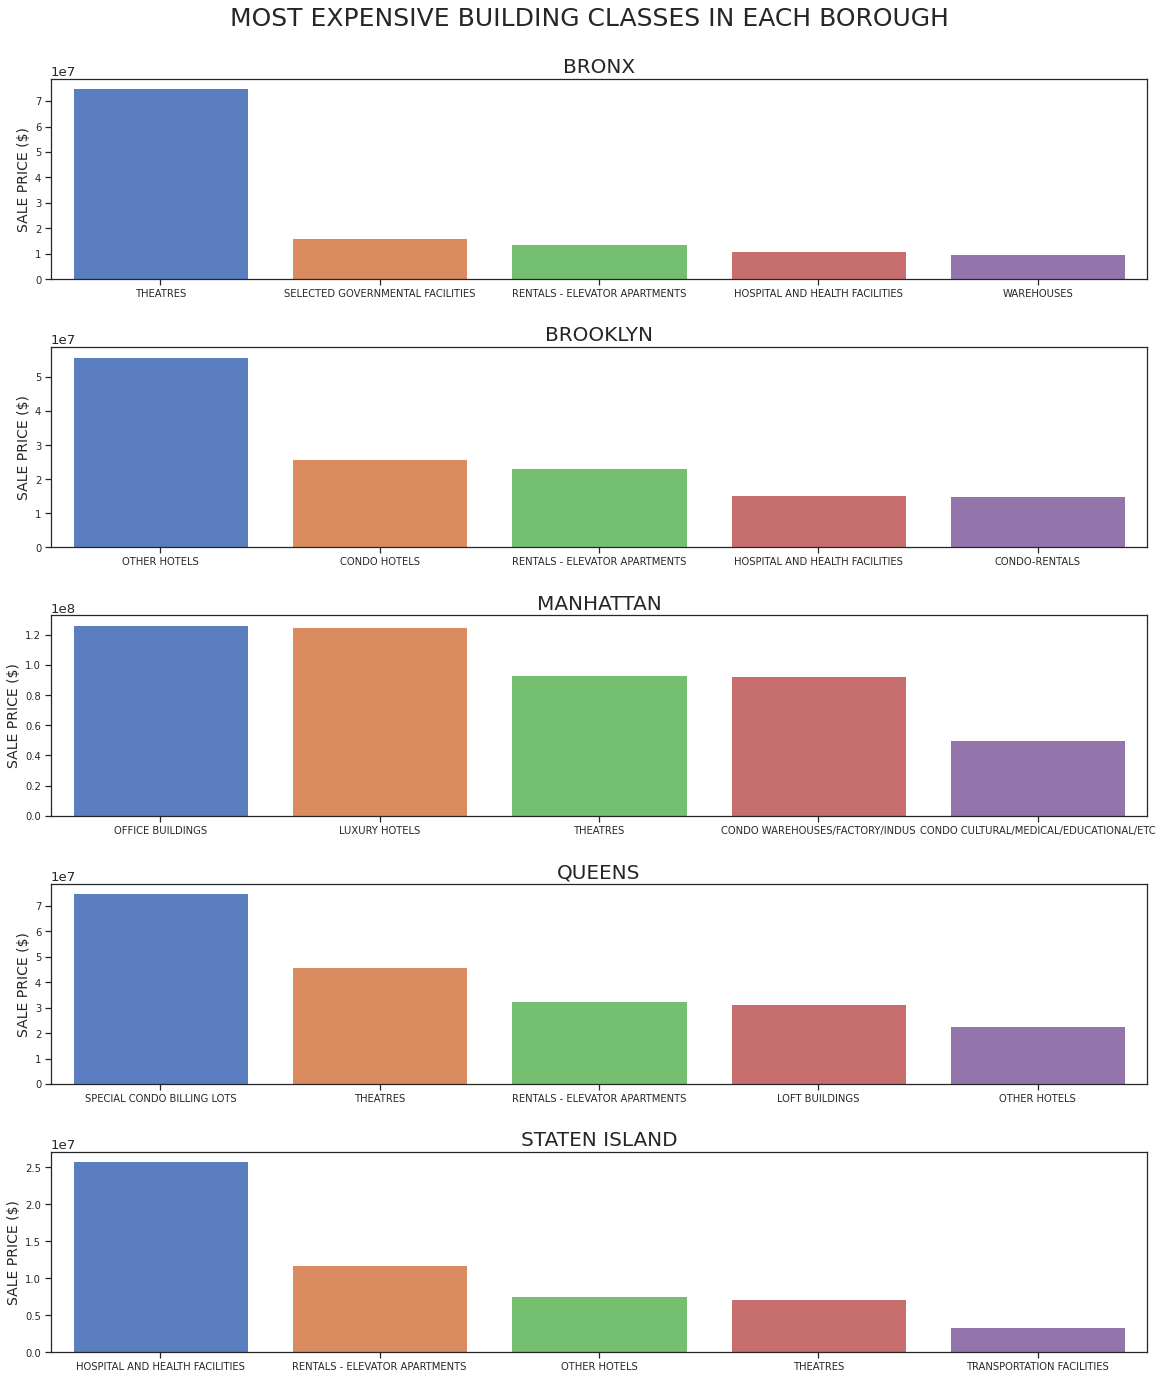

In [0]:
# Most expensive building classes sold in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('MOST EXPENSIVE BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=False).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('SALE PRICE ($)',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()


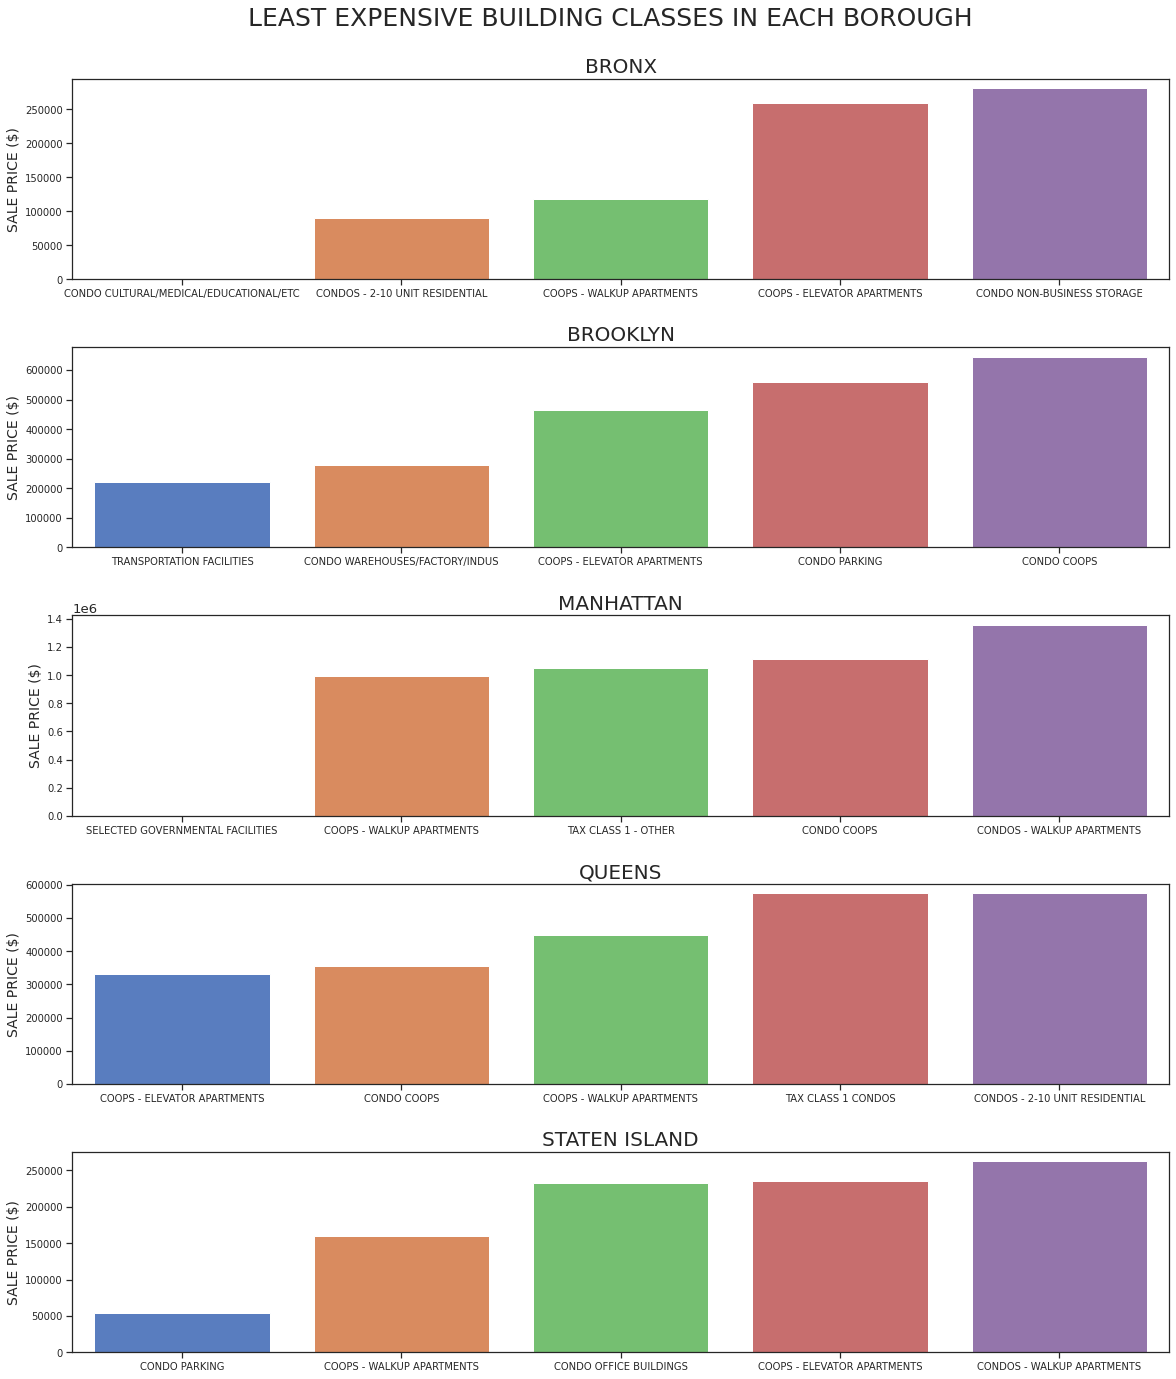

In [0]:
# The least expensive building classes in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('LEAST EXPENSIVE BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=True).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('SALE PRICE ($)',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()

I notice that the most expensive properties in each borough were commerical buildings such as theaters, hotels and office buildings while the least expensive properties were residental buildings such as Co-ops and Condos. What's fascinating is that two government facilities in Manhattan and one transportation facilities got included in the least expensive property list. This peak my interest, so I look for the details of their sale transactions. 

In [0]:
nyc_property_sales[(nyc_property_sales['BOROUGH']=='BROOKLYN')&(nyc_property_sales['BUILDING CLASS']=='TRANSPORTATION FACILITIES')]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
121733,BROOKLYN,MILL BASIN,TRANSPORTATION FACILITIES,WHITMAN DRIVE,5893,0,1960,220000.0,May,2017,May 2017


In [0]:
nyc_property_sales[(nyc_property_sales['BOROUGH']=='MANHATTAN')&(nyc_property_sales['BUILDING CLASS']=='SELECTED GOVERNMENTAL FACILITIES')]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
90070,MANHATTAN,HARLEM-CENTRAL,SELECTED GOVERNMENTAL FACILITIES,120 EAST 125 STREET,2523,8500,1950,1.0,Jan,2017,Jan 2017
161911,MANHATTAN,LOWER EAST SIDE,SELECTED GOVERNMENTAL FACILITIES,269 HENRY STREET,1962,6041,1900,1.0,Oct,2017,Oct 2017


## What were the sizes of the properties sold in each borough?

In [0]:
nyc_property_sales.groupby('BOROUGH')['LAND SQUARE FEET'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
BRONX,20049.0,8778.672552,212357.466357,0.0,1.0,2295.0,2846.0,19850400.0
BROOKLYN,55848.0,2384.848141,11823.004431,0.0,0.0,1800.0,2400.0,970000.0
MANHATTAN,51432.0,1265.219163,7678.890953,0.0,0.0,0.0,0.0,659375.0
QUEENS,70103.0,3225.590103,22405.154429,0.0,0.0,2070.0,3392.0,4228300.0
STATEN ISLAND,23774.0,7466.450534,39622.199931,0.0,2000.0,3107.0,4640.0,3014056.0


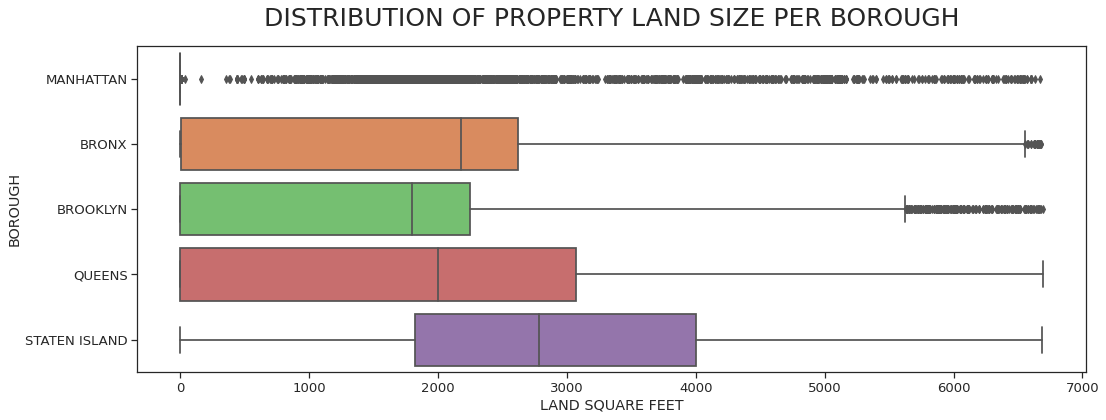

In [0]:
# Land square feet across boroughs. For visual purposes, I graph between the 0.05 and 0.95 quantile.
sqft_cleaned = nyc_property_sales[nyc_property_sales['LAND SQUARE FEET'].between(nyc_property_sales['LAND SQUARE FEET'].quantile(.05), nyc_property_sales['LAND SQUARE FEET'].quantile(.95))]
plt.figure(figsize=(17,6))
sns.boxplot(x='LAND SQUARE FEET', y='BOROUGH', data=sqft_cleaned)
plt.title('DISTRIBUTION OF PROPERTY LAND SIZE PER BOROUGH', fontsize=25, pad=20)
plt.show()

Ploting the spread of land square feet for properties sold, I see that the 4 boroughs mentioned before, Bronx, Brooklyn, Queens, and Staten Island are indeed more spacious than Manhattan. These 4 boroughs have a higher interquartile range for land square feet than Manhattan. A large number of properties sold in Manhattan have a land square feet of 0, meaning that people just purchased the structure not the land. 

##  Were there more newer or older properties sold?

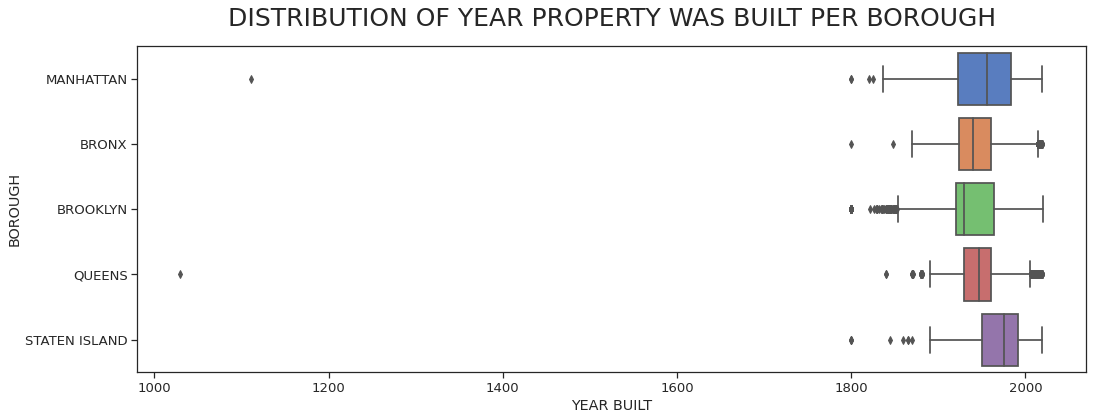

In [0]:
# Year built of properties sold across boroughs
plt.figure(figsize=(17,6))
sns.boxplot(x='YEAR BUILT', y='BOROUGH', data=nyc_property_sales)
plt.title('DISTRIBUTION OF YEAR PROPERTY WAS BUILT PER BOROUGH', fontsize=25, pad=20)
plt.show()

Manhattan and Staten Island sold slighty more newer buildings than the other boroughs.

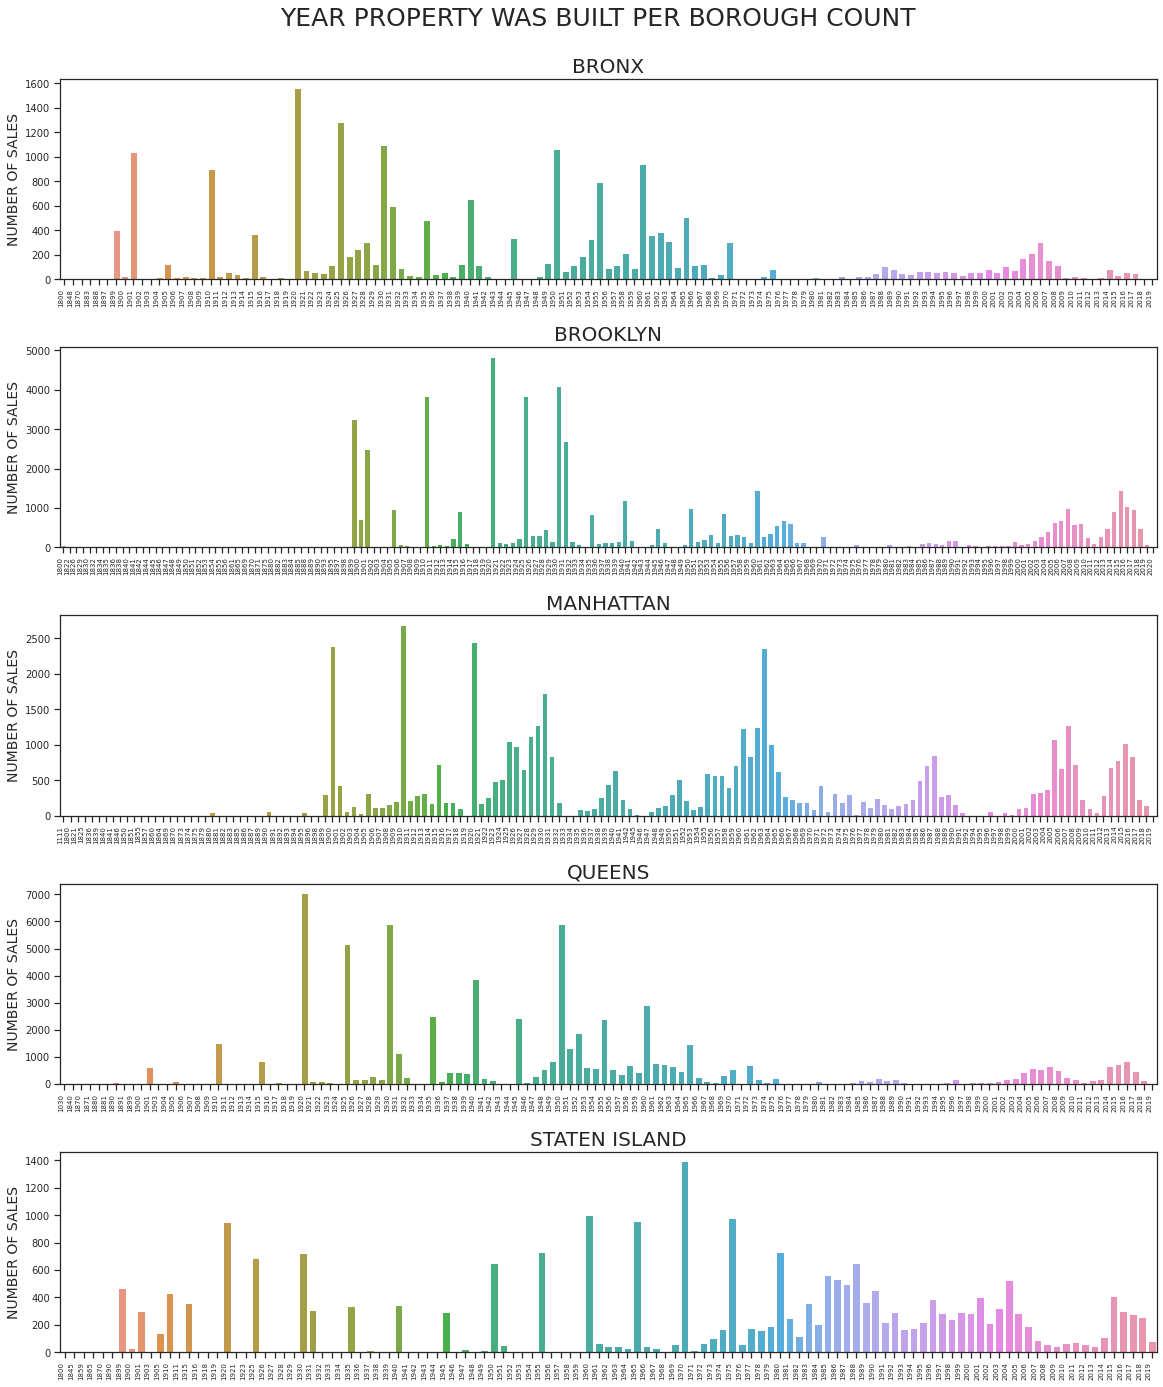

In [0]:
# Year built of properties sold across boroughs
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('YEAR PROPERTY WAS BUILT PER BOROUGH COUNT', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  data_used = building_by_borough.get_group(group)['YEAR BUILT'].value_counts().reset_index()
  b = sns.barplot(y='COUNT', x='YEAR BUILT', data=building_by_borough.get_group(group)['YEAR BUILT'].value_counts().reset_index().rename(columns={'YEAR BUILT':'COUNT','index':'YEAR BUILT'}).sort_values(by='COUNT'), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('NUMBER OF SALES',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)
  b.set_xticklabels(b.get_xticklabels(), size=7, rotation=90, horizontalalignment='right')

fig.show()

## What affects Sale Price?

Does land square feet affect sale price?

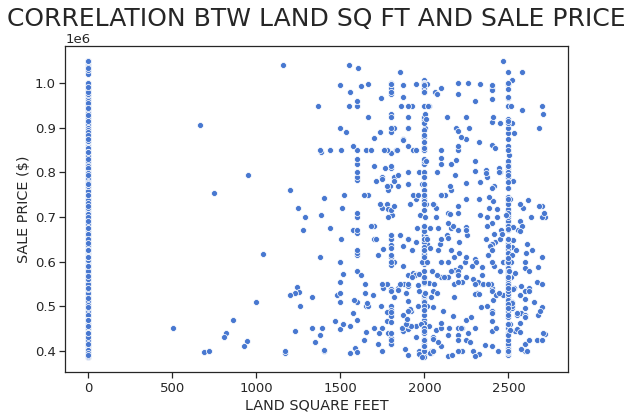

In [0]:
# Land square feet vs sale price
# For visual purposes, I excluded outliers (top and bottom 25%) and only graphed 20% of the population.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['LAND SQUARE FEET'].between(nyc_property_sales['LAND SQUARE FEET'].quantile(.25), nyc_property_sales['LAND SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='LAND SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.title('CORRELATION BTW LAND SQ FT AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [0]:
# Correlation between sale price and land square feet
print('Correlation between Land Square Feet and Sale Price:')
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['LAND SQUARE FEET'])

Correlation between Land Square Feet and Sale Price:


0.021908844805559307

There is almost no correlation (well 0.02 to be exact) between sale price and lands square feet.

So, what about gross square feet? Does that affect sale price?

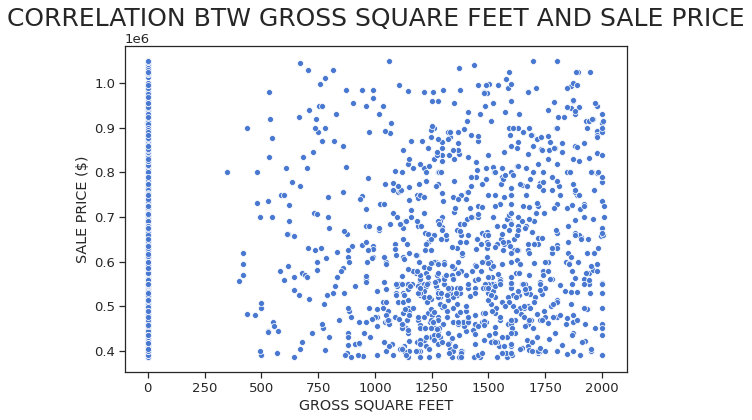

In [0]:
# Gross square feet vs sale price
# For visual purposes, I excluded outliers (top and bottom 25%) and only graphed 20% of the population.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['GROSS SQUARE FEET'].between(nyc_property_sales['GROSS SQUARE FEET'].quantile(.25), nyc_property_sales['GROSS SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.title('CORRELATION BTW GROSS SQUARE FEET AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [0]:
# Correlation of sale price and gross square feet
print('Correlation between Gross Square Feet and Sale Price:')
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['GROSS SQUARE FEET'])

Correlation between Gross Square Feet and Sale Price:


0.46040879435731275

Although not visible in the graph, gross square feet has a slight correlation with sale price. The correlation between the two is 0.46. This correlation is higher than the one we found with land square feet which makes sense because gross square feet is usually greater than lands square feet and more floors and space means a higher price.

And what about the year in which the property was built? Does that affect sale price?

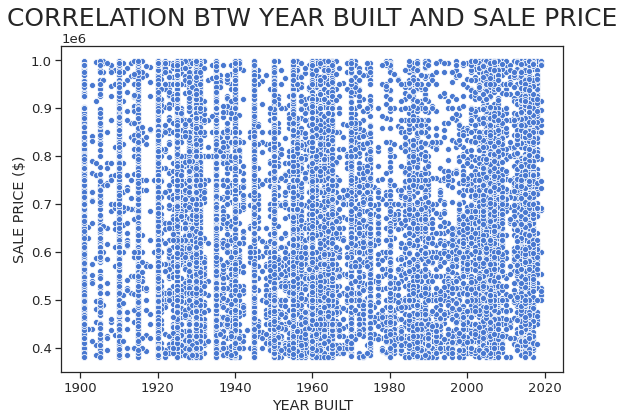

In [0]:
# Year built vs sale price
# For visual purposes, I excluded outliers (top and bottom 25%) and only graphed 20% of the population.
year_built_cleaned = nyc_property_sales[nyc_property_sales['YEAR BUILT']>1900]
x = year_built_cleaned[year_built_cleaned['SALE PRICE'].between(year_built_cleaned['SALE PRICE'].quantile(.25), year_built_cleaned['SALE PRICE'].quantile(.75))]
year_built_cleaned_sample = x.sample(frac=0.2)

sns.scatterplot(x='YEAR BUILT', y='SALE PRICE', data=year_built_cleaned_sample)
plt.title('CORRELATION BTW YEAR BUILT AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [0]:
# Correlation of sale price and year built
print('Correlation between Sale Price and Year Built:')
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['YEAR BUILT'])

Correlation between Sale Price and Year Built:


0.004087004746851288

There is no correlation between the sale price and the year in which the property was built.

# Summary

I spend most of my time on this report cleaning the data set. I dropped many null entries and false values but with what's left, I found trends and that allow me to make the following insights:


*   NYC property prices range greatly so there is really something for everyone. If you are on a tight budget, look into the boroughs Bronx and Staten Island and building types co-ops and condos. However, if money is not an issue, you can consider purchasing commerical buildings in Manhattan.
*   Property space is limited in Manhattan. If you are looking for a more spacious property, Staten Island should be the first borough you explore. 
*   The price of a property and its age are not correlated meaning that older and newer buildings can sell for similar prices. Don't let the year in which the property was built suave your decision too greatly.

